### Importing Required Libraries

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Analysis of Labelled and Unlabelled Data

In [2]:
# Unlabelled Data
unlabelled=pd.read_csv('/content/drive/MyDrive/Dataset/UNGDC/unlabelled_data.csv')

In [3]:
unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


In [4]:
# Labelled Data
labelled=pd.read_csv('/content/drive/MyDrive/Dataset/UNGDC/labelled_data.csv')
labelled

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"I congratulate you, Sir, on your election as P...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,I am sure we will all benefit from your long e...,AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,Australia enjoys strong bonds of friendship wi...,AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,Australia warmly welcomes to membership of thi...,AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"Equally, as a country of the Asia-Pacific regi...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"As a small country, we care for all those who ...",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"As a digital society, we are a story of hope a...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"Again, as a digital State, we consider transpa...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,We are adamant supporters of rules-based decis...,EST,2017,democracy,0.0


In [5]:
# Removing labelled senteces from unlabelled dataset

mask = unlabelled['country'].isin(labelled['country']) & unlabelled['year'].isin(labelled['year']) & unlabelled['doc_id'].isin(labelled['doc_id'])
final_unlabelled = unlabelled[~mask]
final_unlabelled

,Unnamed: 0,doc_id,text,country,year
0,0,ARG_25_1970.txt.1,177.\t : It is a fortunate coincidence that pr...,ARG,1970
1,1,ARG_25_1970.txt.2,"On behalf of the Argentine Government, it is a...",ARG,1970
2,2,ARG_25_1970.txt.3,178.,ARG,1970
3,3,ARG_25_1970.txt.4,Through you I should also like to express the ...,ARG,1970
4,4,ARG_25_1970.txt.5,179.,ARG,1970
...,...,...,...,...,...
2041695,2041695,ZWE_75_2020.txt.63,Ladies and Gentlemen.,ZWE,2020
2041696,2041696,ZWE_75_2020.txt.64,Let me conclude by reaffirming Zimbabwe’s comm...,ZWE,2020
2041697,2041697,ZWE_75_2020.txt.65,There is no better way of achieving a peaceful...,ZWE,2020
2041698,2041698,ZWE_75_2020.txt.66,Recommitting ourselves to these ideals will pa...,ZWE,2020


### Analysis of labels

1. Distribution of labels


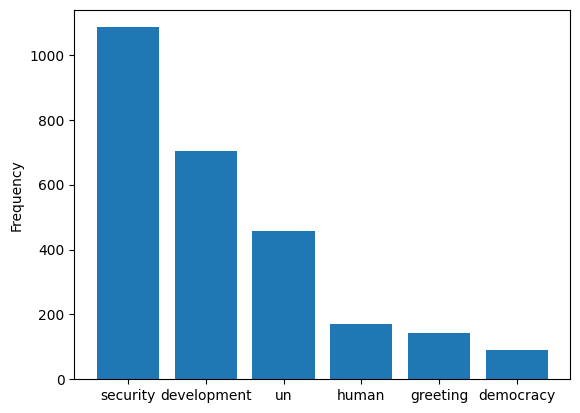

In [6]:
freq = labelled['coding'].value_counts()
plt.bar(freq.index, freq.values)
plt.ylabel('Frequency')
plt.show()

### Preprocessing

1. Remove stopwords (the, a , an...).
2. Remove punctuation (:, , ., ?...).
3. Remove Numbers (1, 199, 12)
4. Remove whitespaces.
5. Converting words into lowercase
6. Tokenization (sentence -> list of words)

In [7]:
def load_sentences(data, type='train'):
  
  '''
    Extracts features and labels from dataset

  '''
  
  sentences, labels = [], []
  sentences = list(data['text'])

  if type == 'train':
    labels = list(data['coding'])
  sentences = [sentence.split('\t') for sentence in sentences]

  return sentences, labels

In [8]:
# Labelled Data
train_sentences, train_labels = load_sentences(labelled, 'train')

print('Training Sentences: ',len(train_sentences))
print('Training Labels: ',len(train_labels))
print('Training Example: ',train_sentences[0])

# Unlabelled Data
test_sentences, _ = load_sentences(final_unlabelled, 'test')

print('Testing Sentences: ',len(test_sentences))
print('Testing Example: ',test_sentences[16])

Training Sentences:  2650
Training Labels:  2650
Training Example:  ['I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.']
Testing Sentences:  2039133
Testing Example:  ['The so-called "European concert" is good proof of this concept which restricted the active access of the nonEuropean states to international life.']


### **Functions**

##### Preprocessor class

1. Removes punctuations, numbers, whitespaces
2. Converts sentences into lower case

##### remove_stopword function

1. Removes Stopwords
2. Tokenizes Sentences

##### empty_sentences function

1. Removes the sentences with less than 2 words

In [9]:
class Preprocessor:
  '''
    Removes punctuations, numbers, whitespaces
    Converts sentences into lower case
  '''
  def __init__(self, numbers=True, punct=True):
    self.numbers = numbers
    self.punct = punct

  def apply(self, sentence):
    sentence = sentence.lower()
    if self.numbers:
      sentence = Preprocessor.remove_numbers(sentence)
    if self.punct: 
      sentence = Preprocessor.remove_punct(sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence
  
  @staticmethod
  def remove_punct(sentence):
    sentence = re.sub(r'[^\w\s]', '', sentence)
    return sentence
  
  @staticmethod
  def remove_numbers(sentence):
    sentence = re.sub(r'[0-9]', '', sentence)
    return sentence

In [10]:
# Example of preprocessor class
print('Before: ', train_sentences[0][0])
processor = Preprocessor()
print('After: ', processor.apply(train_sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  i congratulate you sir on your election as president of the fortysixth session of the general assembly


In [11]:
def remove_stopwords(data):
  '''
    Removes Stopwords
    Tokenizes Sentences
    
  '''
  sentences = []
  split_sent = data.split()
  stopwords_set = set(stopwords.words('english'))
  sentences = [word for word in split_sent if word.lower() not in stopwords_set]
  return sentences

In [12]:
# Example of Removing stopwords and Tokenization
print('Before: ', train_sentences[0][0])
print('After: ', remove_stopwords(train_sentences[0][0]))

Before:  I congratulate you, Sir, on your election as President of the forty-sixth session of the General Assembly.
After:  ['congratulate', 'you,', 'Sir,', 'election', 'President', 'forty-sixth', 'session', 'General', 'Assembly.']


In [13]:
processor = Preprocessor()

# Labelled Data
train_clean_sentences = []
for idx, sentence in tqdm(enumerate(train_sentences)):
  clean_sentence = processor.apply(sentence[0])
  train_clean_sentences.append(remove_stopwords(clean_sentence))


# Unlabelled data
# test_clean_sentences = []
# for idx, sentence in tqdm(enumerate(test_sentences)):
#   clean_sentence = processor.apply(sentence[0])
#   test_clean_sentences.append(remove_stopwords(clean_sentence))

2650it [00:00, 6838.05it/s]


In [14]:
labelled

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"I congratulate you, Sir, on your election as P...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,I am sure we will all benefit from your long e...,AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,Australia enjoys strong bonds of friendship wi...,AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,Australia warmly welcomes to membership of thi...,AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"Equally, as a country of the Asia-Pacific regi...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"As a small country, we care for all those who ...",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"As a digital society, we are a story of hope a...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"Again, as a digital State, we consider transpa...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,We are adamant supporters of rules-based decis...,EST,2017,democracy,0.0


In [15]:
processor_for_df = Preprocessor()

# Labelled Data
labelled_cleaned=labelled.copy()
labelled_cleaned['text']=labelled_cleaned['text'].apply(lambda sentence: processor_for_df.apply(sentence))
labelled_cleaned['text']=labelled_cleaned['text'].apply(remove_stopwords)
# labelled_cleaned['text']=labelled_cleaned['text'].apply(lambda sentence: ' '.join(remove_stopwords(sentence)))


# Unlabelled data
# test_clean_sentences = []
# for idx, sentence in tqdm(enumerate(test_sentences)):
#   clean_sentence = processor.apply(sentence[0])
#   test_clean_sentences.append(remove_stopwords(clean_sentence))

In [16]:
print('Example of a cleaned sentence')
print(train_clean_sentences[0])

Example of a cleaned sentence
['congratulate', 'sir', 'election', 'president', 'fortysixth', 'session', 'general', 'assembly']


In [17]:
# checking for empty sentences
def empty_sentences(data):
  
  '''
    Removes the sentences with less than 2 words
  '''
  print('Length before', len(data))

  sentences = [sublist for sublist in data if not all(elem == "" for elem in sublist)]
  train_sentences = []
  removed_indices = []
  removed_sentences = []
  train_indices=[]
  for idx, sentence in enumerate(sentences):
    if len(sentence) <= 2:
      removed_indices.append(idx)
      removed_sentences.append(sentence)
    else:
      train_sentences.append(sentence)
      train_indices.append(idx)
  print('Length after', len(train_sentences))
  
  return train_indices, train_sentences, removed_indices, removed_sentences

In [18]:
# Labelled Data
print("Labelled data")
train_indices, train_sentences, train_removed_indices, train_removed_sentences = empty_sentences(labelled_cleaned['text'])
labelled_cleaned.drop(train_removed_indices, inplace=True)
print()

# Unlabelled data
# print("unlabelled data")
# test_sentences, test_indices, removed_test_sentences = empty_sentences(test_clean_sentences)

Labelled data
Length before 2650
Length after 2604



### **Encoding**

-- BERT

In [19]:
labelled_cleaned

,Unnamed: 0,doc_id,text,country,year,coding,difficult
0,AUS_46_1991.txt.1,AUS_46_1991.txt.1,"[congratulate, sir, election, president, forty...",AUS,1991,greeting,0.0
1,AUS_46_1991.txt.2,AUS_46_1991.txt.2,"[sure, benefit, long, experience, united, nati...",AUS,1991,greeting,0.0
2,AUS_46_1991.txt.3,AUS_46_1991.txt.3,"[australia, enjoys, strong, bonds, friendship,...",AUS,1991,greeting,0.0
3,AUS_46_1991.txt.4,AUS_46_1991.txt.4,"[australia, warmly, welcomes, membership, body...",AUS,1991,greeting,0.0
4,AUS_46_1991.txt.5,AUS_46_1991.txt.5,"[equally, country, asiapacific, region, welcom...",AUS,1991,greeting,0.0
...,...,...,...,...,...,...,...
2645,EST_72_2017.txt.92,EST_72_2017.txt.92,"[small, country, care, vulnerable, world]",EST,2017,security,0.0
2646,EST_72_2017.txt.93,EST_72_2017.txt.93,"[digital, society, story, hope, rapid, transfo...",EST,2017,development,0.0
2647,EST_72_2017.txt.94,EST_72_2017.txt.94,"[digital, state, consider, transparency, close...",EST,2017,human,0.0
2648,EST_72_2017.txt.95,EST_72_2017.txt.95,"[adamant, supporters, rulesbased, decisionmaki...",EST,2017,democracy,0.0


In [20]:
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 37.7 MB/s eta 0:00:00


In [21]:
import os
import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_datasets as tfds
import tensorflow_text
import numpy as np

In [22]:
# preprocessor = hub.KerasLayer(
#     "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

In [23]:
# model = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4')

In [24]:
# def get_embeddings(sentences):
#   preproc_text = preprocessor(sentences)
#   return model(preproc_text)['pooled_output']

In [25]:
# encoded_train = get_embeddings(['More than 4,000 years after their construction, the pyramids still stand as some of the most important and mysterious tombs in the world',
#                                 'Venu can eat shit',
#                                 'The Egyptian pyramids are some of the most incredible man-made structures in history.'])

In [26]:
from sklearn.metrics.pairwise import cosine_similarity

In [27]:
# print(cosine_similarity([encoded_train[0]], [encoded_train[1]]))
# print(cosine_similarity([encoded_train[0]], [encoded_train[2]]))
# print(cosine_similarity([encoded_train[1]], [encoded_train[2]]))

In [28]:
train_clean_labels=[train_labels[idx] for idx in train_indices]

In [29]:
# corpus_train_sent = []
# for sentence in train_sentences:
#   corpus_train_sent.append(" ".join(sentence))
# encoded_train = get_embeddings(corpus_train_sent)

In [31]:
!pip install node2vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 21.1 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.1
    Uninstalling networkx-3.1:
      Successfully uninstalled networkx-3.1


In [32]:
import networkx as nx
from node2vec import Node2Vec

In [33]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 59.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 46.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 48.3 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=47f5f4ac853a05214b7ce6b044fbaeb2df2f94f0803cbf303966b71da94b335c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [34]:
from sentence_transformers import SentenceTransformer
model_sentence_transformer = SentenceTransformer('sentence-transformers/bert-base-nli-mean-tokens')

In [35]:
# encoded_sentences=get_embeddings([ ' '.join(train_clean_sentences[i]) for i in labelled_cleaned['text']])

In [36]:
labelled_cleaned['embeddings']=[' '.join(i) for i in labelled_cleaned['text']]
labelled_cleaned['embeddings']=labelled_cleaned['embeddings'].apply(model_sentence_transformer.encode)

### **Graph**

In [37]:
nodes_df=pd.DataFrame([[i, labelled_cleaned['coding'][i]] for i in labelled_cleaned.index ])

In [38]:
from itertools import combinations

In [39]:
edge_country=[]
for country in set(labelled_cleaned['country']):
    subset=labelled_cleaned[labelled_cleaned['country']==country]
    edges_subset=list(combinations(subset.index, 2))
    for e in edges_subset:
        edge_country.append(e)

In [40]:
edge_year=[]
for year in set(labelled_cleaned['year']):
    subset=labelled_cleaned[labelled_cleaned['year']==year]
    edges_subset=list(combinations(subset.index, 2))
    for e in edges_subset:
        edge_year.append(e)

In [41]:
cos_sim=0.9
edges_subset=list(combinations(labelled_cleaned.index, 2))
edge_sim=[]
for idx1, idx2 in tqdm(edges_subset):
    # print(f"{labelled_cleaned['embeddings'][idx1].shape}\t{labelled_cleaned['embeddings'][idx2].shape}", end='')
    cosine_sim_val=cosine_similarity([labelled_cleaned['embeddings'][idx1]], [labelled_cleaned['embeddings'][idx2]])
    if cosine_sim_val>cos_sim:
        edge_sim.append([idx1, idx2])
        # print("Appended")
    # print(end='\r')

100%|██████████| 3389106/3389106 [24:49<00:00, 2275.96it/s]


In [42]:
edge_sim

[[0, 471],
 [18, 318],
 [18, 686],
 [82, 566],
 [112, 138],
 [116, 255],
 [148, 1250],
 [152, 488],
 [305, 318],
 [305, 459],
 [305, 478],
 [310, 830],
 [310, 2618],
 [317, 2027],
 [318, 459],
 [318, 478],
 [404, 414],
 [414, 1519],
 [425, 544],
 [459, 478],
 [618, 1785],
 [618, 2065],
 [710, 1515],
 [784, 786],
 [803, 2272],
 [996, 2272],
 [1493, 1544],
 [1544, 1545],
 [1877, 1883],
 [1978, 1981],
 [2054, 2065],
 [2139, 2144],
 [2155, 2157],
 [2155, 2159],
 [2157, 2159],
 [2167, 2234],
 [2226, 2635]]

In [54]:
G = nx.Graph()
G.add_nodes_from(train_indices)
G.add_edges_from(edge_sim)
# G.add_edges_from(edge_country)
# G.add_edges_from(edge_year)

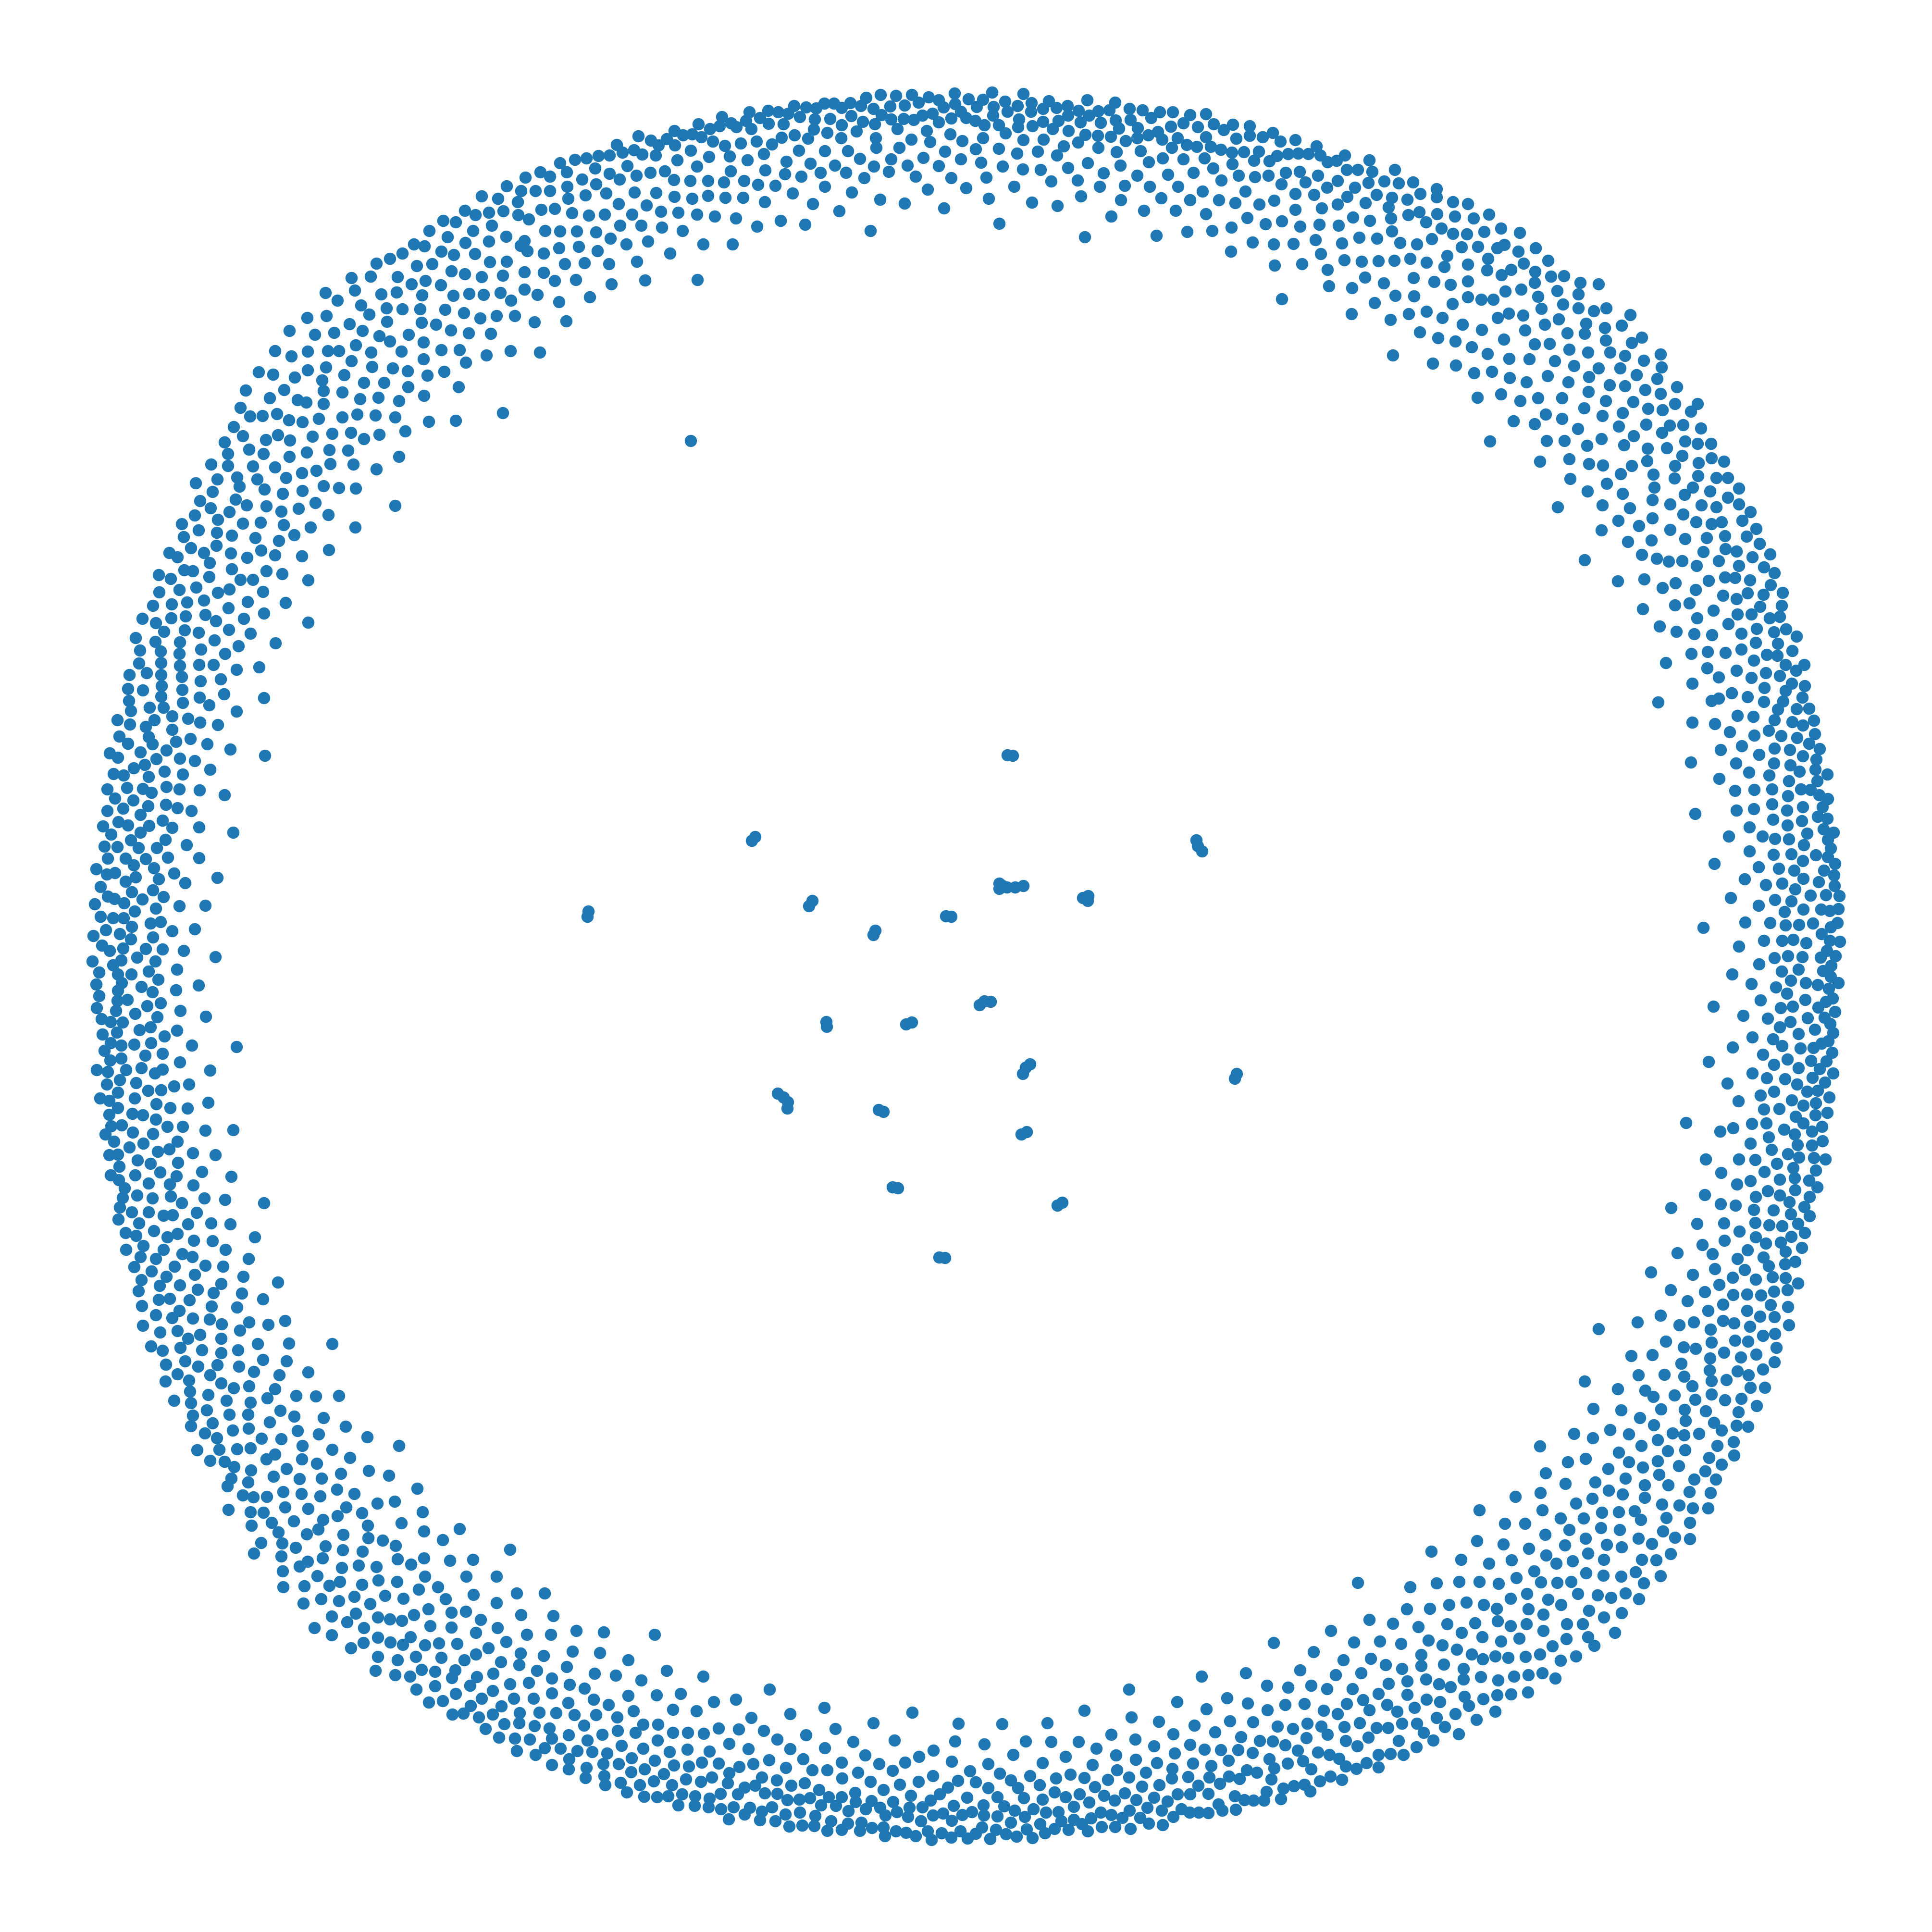

In [70]:
plt.figure(figsize=(40,40))
nx.draw(G)

### **Node2Vec**

In [56]:
embedding_size=512
walk_length=30 #10
num_walks=160 #80
window=20 #10
connect_type='sim'
filename=f"emb{embedding_size}_wklen{walk_length}_nwalk{num_walks}_win{window}_cossim{cos_sim}_{connect_type}"
node2vec = Node2Vec(G, dimensions=embedding_size, walk_length=walk_length,num_walks=num_walks, workers=4)
node2vec_model = node2vec.fit(window=window, min_count=1,batch_words=4)

embeddings_map = node2vec_model.wv
embeddings = embeddings_map[[i for i in range(len(G.nodes))]]
node2vec_model.save(filename+'.model')
node2vec_model.wv.save_word2vec_format(filename+'.emb')

Computing transition probabilities:   0%|          | 0/2604 [00:00<?, ?it/s]

In [57]:
# from gensim.models import Word2Vec
# node2vec_model=Word2Vec.load('/content/drive/MyDrive/Dataset/UNGDC/emb1024_wklen30_nwalk160_win20.model')
# embeddings_map = node2vec_model.wv
# embeddings = embeddings_map[[i for i in range(len(G.nodes))]]
# embedding_size=128

In [58]:
embeddings.shape

(2604, 512)

### **GNN**

In [60]:
from sklearn.preprocessing import StandardScaler
adj = nx.to_scipy_sparse_array(G).tocoo()
row = tf.convert_to_tensor(adj.row.astype(np.int64))
col = tf.convert_to_tensor(adj.col.astype(np.int64))
edge_index = tf.stack([row, col], axis=0)
features = np.array(list(dict(G.degree()).values()))

scale = StandardScaler()
features = scale.fit_transform(features.reshape(-1,1))

In [61]:
print("Num GPUs Available: ", 
tf.config.experimental.list_physical_devices())

Num GPUs Available:  [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [62]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Softmax


class MLPTF(Model):
    def __init__(self, hidden_dim, num_class):
        """ MLP Model using tensorflow.keras
        Args:
            feature_dim: feature dimension
            hidden_dim: hidden units
            num_class: number of class
            lambda_: lambda in L2 regularizer
        """
        super().__init__()
        # Start your code here (initialize weight and bias)
        
        self.dense1 = Dense(hidden_dim[0], activation='relu',use_bias=True, kernel_regularizer=tf.keras.regularizers.L2(), bias_regularizer=tf.keras.regularizers.L2())
        tf.keras.layers.Dropout(0.5),
        self.dense1 = Dense(hidden_dim[1], activation='relu',use_bias=True, kernel_regularizer=tf.keras.regularizers.L2(), bias_regularizer=tf.keras.regularizers.L2())
        tf.keras.layers.Dropout(0.5),
        # self.dense1 = Dense(hidden_dim[2], activation='relu',use_bias=True, kernel_regularizer=tf.keras.regularizers.L2(), bias_regularizer=tf.keras.regularizers.L2())
        # tf.keras.layers.Dropout(0.5),
        self.dense2 = Dense(num_class, use_bias=True)
        self.softmax = Softmax()

        # End
        
    def call(self, x):
        """ Forward function of tf. It should be named 'call'
        
        Args:
            x: (n x feature_dim) tensor
        Returns:
            y_hat: (n x num_class) tensor
        """
        # Start your code here (Forward)

        y1 = self.dense1(x)
        y2 = self.dense2(y1)
        y_hat = self.softmax(y2)

        # End
        return y_hat

In [63]:
labels={'security': 0, 
        'greeting': 1, 
        'development': 2, 
        'democracy': 3, 
        'human': 4, 
        'un': 5}

In [64]:
train_mapped_labels=[labels[i] for i in labelled_cleaned['coding'].values]

In [65]:
train_labels_one_hot=tf.one_hot(
    train_mapped_labels,
    1)

In [66]:
model_tf=MLPTF(hidden_dim=[128, 16], num_class=len(labels))
# model_tf.build(input_shape=(None, embeddings.shape[1]))
model_tf.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.1),
              loss='sparse_categorical_crossentropy')
# model_tf.summary()

In [67]:
tf_history = model_tf.fit(x=embeddings, y=train_labels_one_hot, epochs=50)

Epoch 1/50
82/82 [==============================] - 1s 3ms/step - loss: 1.0761
Epoch 2/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7889
Epoch 3/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7383
Epoch 4/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7173
Epoch 5/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7093
Epoch 6/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7049
Epoch 7/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7028
Epoch 8/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7018
Epoch 9/50
82/82 [==============================] - 0s 3ms/step - loss: 0.7001
Epoch 10/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6991
Epoch 11/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6981
Epoch 12/50
82/82 [==============================] - 0s 3ms/step - loss: 0.6971
Epoch 13/50
82/82 [==============================

In [68]:
prediction=model_tf.predict(embeddings)
prediction

82/82 [==============================] - 0s 2ms/step


array([[7.22342193e-01, 2.77039260e-01, 1.24434911e-04, 1.36019313e-04,
        1.59249263e-04, 1.98787078e-04],
       [7.52467096e-01, 2.47111231e-01, 8.16975225e-05, 9.01688545e-05,
        1.08687462e-04, 1.41067518e-04],
       [7.46537805e-01, 2.53009349e-01, 8.83770044e-05, 9.74273498e-05,
        1.16702715e-04, 1.50297361e-04],
       ...,
       [5.73440135e-01, 4.23001081e-01, 8.30940320e-04, 8.73772835e-04,
        8.99870822e-04, 9.54233925e-04],
       [5.73459983e-01, 4.22981709e-01, 8.30799458e-04, 8.73629760e-04,
        8.99735896e-04, 9.54110466e-04],
       [5.73505342e-01, 4.22937930e-01, 8.30404111e-04, 8.73223995e-04,
        8.99348932e-04, 9.53744224e-04]], dtype=float32)

In [69]:
accuracy_score(tf.math.argmax(prediction, axis=1), train_mapped_labels)

0.4112903225806452

In [ ]:
# f1_score(tf.math.argmax(prediction, axis=1), train_mapped_labels, average=None)

In [ ]:
# strin=''.join([str(i) for i in encoded_train])
# tf.io.write_file('encoded_train.txt', strin)
# raw = tf.io.read_file('encoded_train.txt')